In [71]:
import os
import pandas as pd
import numpy as np
import yaml

import seaborn as sns
import matplotlib.pyplot as plt

import re

from utils.training_utils import get_features_attribute
from unidecode import unidecode

import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Leitura dos arquivos auxiliares

In [72]:
features_config = yaml.safe_load(open(os.path.join('..', 'src', 'config', 'feature_config.yaml'), "r"))
features_struct = get_features_attribute(features_config, attribute='struct')
features_struct

{'sale_price': True,
 'shipping': True,
 'seller': True,
 'address': True,
 'attributes': True,
 'location': True,
 'seller_contact': True,
 'installments': True}

# Funções Auxiliares

In [73]:
def unpack_feature(col, feature):
    """Função para desempacotar uma feature de outra no formato struct"""
    
    return col.get(feature) if col else None

In [74]:
def attribute_extract(attributes, key):
    """Função para extrair os atributos desejados da coluna `attributes`"""

    if not isinstance(attributes, (list, np.ndarray)):
        return None
    
    for attribute in attributes:
        if isinstance(attribute, dict) and attribute.get('id') == key:
            return attribute.get('value_name')
    
    return None

In [75]:
def brand_processing(brand):
    """Função realizar a padronização dos nomes das marcas"""
    
    if brand is not None:
        brand = brand.lower()
        return re.sub(r'[^\w\s]', '', brand)
    else:
        return None

In [76]:
def color_name_processing(color):
    """Função realizar o mapping e padronização das cores"""

    if color is not None:
        color = color.lower()
        color = re.sub(r'[^\w\s]', '', color)

        color_dict = {
            'black': ['negro', 'preto'],
            'white': ['blanco', 'branco'],
            'gray': ['gris', 'cinza'],
            'dark gray': ['gris oscuro', 'cinza escuro'],
            'blue': ['azul', 'azul marinho', 'marinho'],
            'silver': ['plateado', 'prateado', 'prata', 'plata'],
            'red': ['rojo', 'vermelho'],
            'green': ['verde'],
            'pink': ['rosa'],
            'yellow': ['amarillo', 'amarelo'],
            'orange': ['naranja', 'laranja'],
            'transparent': ['transparente'],
            'multicolor': ['multicolor'],
            'turquoise': ['turquesa'],
            'brown': ['marron', 'marrom'],
            'purple': ['purpura', 'roxo'],
            'gold': ['dorado', 'ouro'],
            'beige': ['beige', 'bege'],
            'maroon': ['granate', 'marrom escuro'],
            'violet': ['violeta'],
            'magenta': ['magenta'],
            'salmon': ['salmao', 'salmon'],
        }

        if color in color_dict:
            return color
        else:
            for standard_color, aliases in color_dict.items():
                if color in aliases:
                    return standard_color
            return '<other>'
    else:
        return None

In [77]:
def weight_processing(weight_str_value):
    """Função realizar o mapping e padronização das unidades de peso"""

    if type(weight_str_value) == str:
        if weight_str_value.strip() != '':
            value, unit = re.match(r'(-?[\d.,]+)\s*([a-zA-Z]+)', weight_str_value.strip().lower(), re.IGNORECASE).groups()
            conversao = {
                'kg': 1000,
                'g': 1,
                'lb': 453.592,
                'oz': 28.3495,
                'mg': 0.001,
                'mcg': 0.000001,
                't': 1000000
            }
            mult = conversao.get(unit, np.nan)
            return float(value)*mult
    return np.nan

In [78]:
def remove_outliers_iqr(df, feature):
    """Função para remover outliers de uma coluna"""

    df_analyse = df[~df[feature].isna()].copy()

    Q1 = np.percentile(df_analyse[feature], 25)
    Q3 = np.percentile(df_analyse[feature], 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_analyse = df_analyse[(df_analyse[feature] >= lower_bound) & (df_analyse[feature] <= upper_bound)]
    return df_analyse

# Leitura da base raw

In [79]:
df_raw = pd.read_parquet(os.path.join('..', 'data', 'raw', 'amostra_raw.parquet'))

print(df_raw.shape)
df_raw.head()

(285195, 37)


,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,sanitized_title,permalink,buying_mode,site_id,category_id,domain_id,thumbnail,currency_id,order_backend,price,original_price,sale_price,available_quantity,official_store_id,use_thumbnail_id,accepts_mercadopago,shipping,stop_time,seller,address,attributes,installments,winner_item_id,catalog_listing,discounts,promotion_decorations,promotions,inventory_id,official_store_name,location,seller_contact
0,MEC591721600,Consolas Play Station 5 Slim Edicion Digital,new,790276-MLU77965322054_082024,MEC29001054,gold_pro,,https://www.mercadolibre.com.ec/consolas-play-...,buy_it_now,MEC,MEC3533,MEC-GAME_CONSOLES,http://http2.mlstatic.com/D_790276-MLU77965322...,USD,1,659.00,NaN,"{'amount': 659.0, 'conditions': {'context_rest...",50,NaN,True,True,"{'benefits': None, 'free_shipping': True, 'log...",2044-11-15T04:00:00.000Z,"{'id': 63228264, 'nickname': 'MEGACELLCOM'}","{'city_id': 'RUMtUUnDsWFxdWl0bw', 'city_name':...","[{'attribute_group_id': 'OTHERS', 'attribute_g...",None,None,True,None,None,None,None,None,None,None
1,MEC585311472,Auriculares Inalámbricos Xiaomi Redmi Buds 6 P...,new,742884-MLA79765825031_102024,MEC39962085,bronze,,https://www.mercadolibre.com.ec/auriculares-in...,buy_it_now,MEC,MEC121963,MEC-HEADPHONES,http://http2.mlstatic.com/D_742884-MLA79765825...,USD,2,36.89,44.99,"{'amount': 36.89, 'conditions': {'context_rest...",1,NaN,True,True,"{'benefits': None, 'free_shipping': True, 'log...",2044-09-17T04:00:00.000Z,"{'id': 173825591, 'nickname': 'MAS_STORE'}","{'city_id': 'RUMtUUNhcmNlbMOpbg', 'city_name':...","[{'attribute_group_id': 'OTHERS', 'attribute_g...",None,None,True,None,None,None,None,None,None,None
2,MEC573483608,Microsoft Xbox Series X 1tb Carbon Black,new,942133-MLA74651936102_022024,MEC16160759,bronze,,https://www.mercadolibre.com.ec/microsoft-xbox...,buy_it_now,MEC,MEC3533,MEC-GAME_CONSOLES,http://http2.mlstatic.com/D_942133-MLA74651936...,USD,3,887.43,986.04,"{'amount': 887.43, 'conditions': {'context_res...",50,63508.0,True,True,"{'benefits': None, 'free_shipping': True, 'log...",2044-05-11T04:00:00.000Z,"{'id': 200533006, 'nickname': 'GAMING.EC'}","{'city_id': 'RUMtWVFUYXJxdWk', 'city_name': 'T...","[{'attribute_group_id': 'OTHERS', 'attribute_g...",None,None,True,None,None,None,None,GAMINGEC,None,None
3,MEC571416556,Auriculares Gamer G435 Logitech G Wireless Gam...,new,681820-MLU77493029189_072024,MEC18651916,bronze,,https://www.mercadolibre.com.ec/auriculares-ga...,buy_it_now,MEC,MEC116670,MEC-HEADPHONES,http://http2.mlstatic.com/D_681820-MLU77493029...,USD,4,82.22,91.36,"{'amount': 82.22, 'conditions': {'context_rest...",1,63508.0,True,True,"{'benefits': None, 'free_shipping': True, 'log...",2044-04-19T04:00:00.000Z,"{'id': 200533006, 'nickname': 'GAMING.EC'}","{'city_id': 'RUMtWVFUYXJxdWk', 'city_name': 'T...","[{'attribute_group_id': 'OTHERS', 'attribute_g...",None,None,True,None,None,None,None,GAMINGEC,None,None
4,MEC568777050,Oculus Quest 2 Advanced All In One Casco Vr 12...,new,929895-MLA51988203957_102022,MEC21236885,bronze,,https://www.mercadolibre.com.ec/oculus-quest-2...,buy_it_now,MEC,MEC3533,MEC-GAME_CONSOLES,http://http2.mlstatic.com/D_929895-MLA51988203...,USD,5,443.70,493.00,"{'amount': 443.7, 'conditions': {'context_rest...",1,63508.0,True,True,"{'benefits': None, 'free_shipping': True, 'log...",2044-04-11T18:10:25.097Z,"{'id': 200533006, 'nickname': 'GAMING.EC'}","{'city_id': 'RUMtWVFUYXJxdWk', 'city_name': 'T...","[{'attribute_group_id': 'OTHERS', 'attribute_g...",None,None,True,None,None,None,None,GAMINGEC,None,None


In [80]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285195 entries, 0 to 285194
Data columns (total 37 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     285195 non-null  object 
 1   title                  285195 non-null  object 
 2   condition              274680 non-null  object 
 3   thumbnail_id           285195 non-null  object 
 4   catalog_product_id     135672 non-null  object 
 5   listing_type_id        285195 non-null  object 
 6   sanitized_title        285195 non-null  object 
 7   permalink              285195 non-null  object 
 8   buying_mode            285195 non-null  object 
 9   site_id                285195 non-null  object 
 10  category_id            285195 non-null  object 
 11  domain_id              285195 non-null  object 
 12  thumbnail              285195 non-null  object 
 13  currency_id            278614 non-null  object 
 14  order_backend          285195 non-nu

In [81]:
(df_raw.shape[0] - df_raw.isnull().sum()) / (df_raw.shape[0])

id                       1.000000
title                    1.000000
condition                0.963130
thumbnail_id             1.000000
catalog_product_id       0.475717
listing_type_id          1.000000
sanitized_title          1.000000
permalink                1.000000
buying_mode              1.000000
site_id                  1.000000
category_id              1.000000
domain_id                1.000000
thumbnail                1.000000
currency_id              0.976925
order_backend            1.000000
price                    0.976925
original_price           0.235369
sale_price               0.838472
available_quantity       1.000000
official_store_id        0.224920
use_thumbnail_id         1.000000
accepts_mercadopago      1.000000
shipping                 1.000000
stop_time                1.000000
seller                   0.999993
address                  0.977454
attributes               1.000000
installments             0.437704
winner_item_id           0.000000
catalog_listin

In [82]:
df_raw.loc[:, (~df_raw.columns.isin(list(features_struct.keys())))] = df_raw.loc[:, (~df_raw.columns.isin(list(features_struct.keys())))].replace('', None)

In [83]:
df_raw.columns[df_raw.isnull().all()]

Index(['sanitized_title', 'winner_item_id', 'discounts',
       'promotion_decorations', 'promotions'],
      dtype='object')

In [84]:
df_raw = df_raw.dropna(axis=1, how='all')

print(df_raw.shape)
df_raw.head()

(285195, 32)


,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,domain_id,thumbnail,currency_id,order_backend,price,original_price,sale_price,available_quantity,official_store_id,use_thumbnail_id,accepts_mercadopago,shipping,stop_time,seller,address,attributes,installments,catalog_listing,inventory_id,official_store_name,location,seller_contact
0,MEC591721600,Consolas Play Station 5 Slim Edicion Digital,new,790276-MLU77965322054_082024,MEC29001054,gold_pro,https://www.mercadolibre.com.ec/consolas-play-...,buy_it_now,MEC,MEC3533,MEC-GAME_CONSOLES,http://http2.mlstatic.com/D_790276-MLU77965322...,USD,1,659.00,NaN,"{'amount': 659.0, 'conditions': {'context_rest...",50,NaN,True,True,"{'benefits': None, 'free_shipping': True, 'log...",2044-11-15T04:00:00.000Z,"{'id': 63228264, 'nickname': 'MEGACELLCOM'}","{'city_id': 'RUMtUUnDsWFxdWl0bw', 'city_name':...","[{'attribute_group_id': 'OTHERS', 'attribute_g...",None,True,None,None,None,None
1,MEC585311472,Auriculares Inalámbricos Xiaomi Redmi Buds 6 P...,new,742884-MLA79765825031_102024,MEC39962085,bronze,https://www.mercadolibre.com.ec/auriculares-in...,buy_it_now,MEC,MEC121963,MEC-HEADPHONES,http://http2.mlstatic.com/D_742884-MLA79765825...,USD,2,36.89,44.99,"{'amount': 36.89, 'conditions': {'context_rest...",1,NaN,True,True,"{'benefits': None, 'free_shipping': True, 'log...",2044-09-17T04:00:00.000Z,"{'id': 173825591, 'nickname': 'MAS_STORE'}","{'city_id': 'RUMtUUNhcmNlbMOpbg', 'city_name':...","[{'attribute_group_id': 'OTHERS', 'attribute_g...",None,True,None,None,None,None
2,MEC573483608,Microsoft Xbox Series X 1tb Carbon Black,new,942133-MLA74651936102_022024,MEC16160759,bronze,https://www.mercadolibre.com.ec/microsoft-xbox...,buy_it_now,MEC,MEC3533,MEC-GAME_CONSOLES,http://http2.mlstatic.com/D_942133-MLA74651936...,USD,3,887.43,986.04,"{'amount': 887.43, 'conditions': {'context_res...",50,63508.0,True,True,"{'benefits': None, 'free_shipping': True, 'log...",2044-05-11T04:00:00.000Z,"{'id': 200533006, 'nickname': 'GAMING.EC'}","{'city_id': 'RUMtWVFUYXJxdWk', 'city_name': 'T...","[{'attribute_group_id': 'OTHERS', 'attribute_g...",None,True,None,GAMINGEC,None,None
3,MEC571416556,Auriculares Gamer G435 Logitech G Wireless Gam...,new,681820-MLU77493029189_072024,MEC18651916,bronze,https://www.mercadolibre.com.ec/auriculares-ga...,buy_it_now,MEC,MEC116670,MEC-HEADPHONES,http://http2.mlstatic.com/D_681820-MLU77493029...,USD,4,82.22,91.36,"{'amount': 82.22, 'conditions': {'context_rest...",1,63508.0,True,True,"{'benefits': None, 'free_shipping': True, 'log...",2044-04-19T04:00:00.000Z,"{'id': 200533006, 'nickname': 'GAMING.EC'}","{'city_id': 'RUMtWVFUYXJxdWk', 'city_name': 'T...","[{'attribute_group_id': 'OTHERS', 'attribute_g...",None,True,None,GAMINGEC,None,None
4,MEC568777050,Oculus Quest 2 Advanced All In One Casco Vr 12...,new,929895-MLA51988203957_102022,MEC21236885,bronze,https://www.mercadolibre.com.ec/oculus-quest-2...,buy_it_now,MEC,MEC3533,MEC-GAME_CONSOLES,http://http2.mlstatic.com/D_929895-MLA51988203...,USD,5,443.70,493.00,"{'amount': 443.7, 'conditions': {'context_rest...",1,63508.0,True,True,"{'benefits': None, 'free_shipping': True, 'log...",2044-04-11T18:10:25.097Z,"{'id': 200533006, 'nickname': 'GAMING.EC'}","{'city_id': 'RUMtWVFUYXJxdWk', 'city_name': 'T...","[{'attribute_group_id': 'OTHERS', 'attribute_g...",None,True,None,GAMINGEC,None,None


In [85]:
(
    df_raw.loc[:, (~df_raw.columns.isin(list(features_struct.keys()) + ['order_backend']))]
    .duplicated()
    .sum()
)

13555

In [86]:
df_raw = df_raw.drop_duplicates(subset='id', keep='first')

print(df_raw.shape)

(
    df_raw.loc[:, (~df_raw.columns.isin(list(features_struct.keys()) + ['order_backend']))]
    .duplicated()
    .sum()
)

(271640, 32)


0

In [87]:
df_raw['category_id_tratado'] = df_raw.category_id.apply(lambda x: x[3:])

print(f"Número de categorias distintas (considerando o ID do país): {df_raw['category_id'].nunique()}")
print(f"Número de categorias distintas (após tratamento): {df_raw['category_id_tratado'].nunique()}")

df_raw = df_raw.drop('category_id', axis = 1)

Número de categorias distintas (considerando o ID do país): 25011
Número de categorias distintas (após tratamento): 15210


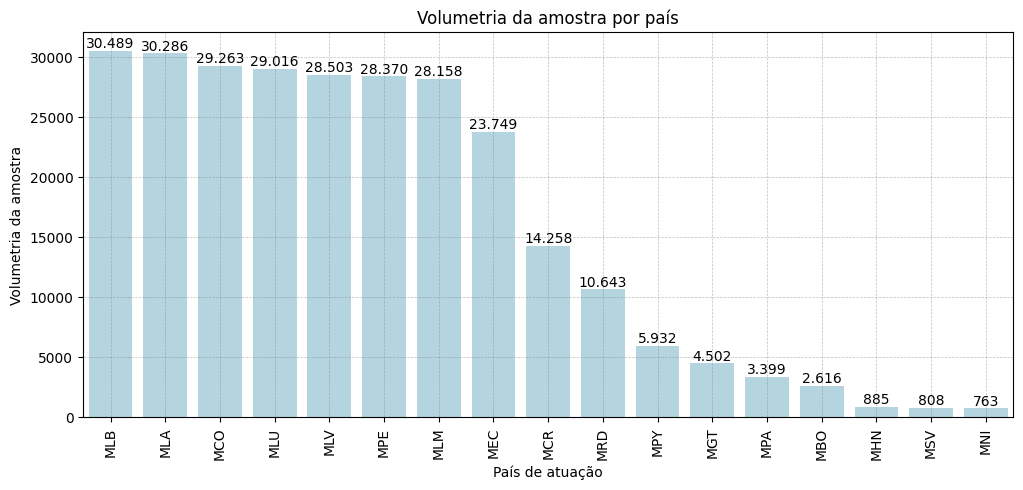

In [88]:
region_counts = df_raw['site_id'].value_counts()

plt.figure(figsize = (12, 5))
ax = sns.barplot(
    x = region_counts.index,
    y = region_counts.values,
    color = 'lightblue'
)

plt.xticks(rotation=90)

for container in ax.containers:
    labels = [f"{val.get_height():,.0f}".replace(',', '.') for val in container]
    ax.bar_label(container, labels=labels) 

plt.xlabel('País de atuação')
plt.ylabel('Volumetria da amostra')
plt.title('Volumetria da amostra por país')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

plt.show()

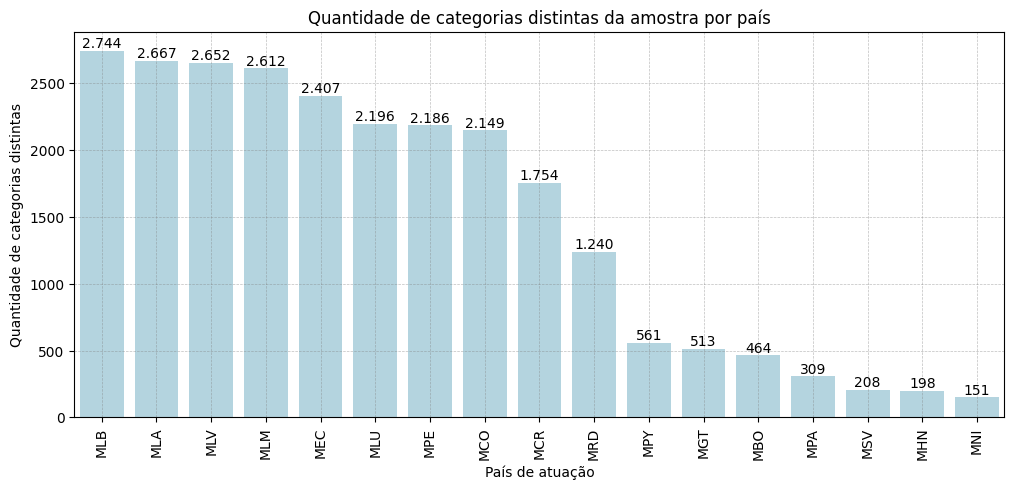

In [89]:
plt.figure(figsize = (12, 5))

ax = sns.barplot(
    x = 'site_id', 
    y = 'num_categories', 
    color = 'lightblue', 
    data = (
        df_raw
        .groupby('site_id', as_index=False)['category_id_tratado']
        .nunique()
        .rename(columns = {'category_id_tratado': 'num_categories'})
    ).sort_values(by = 'num_categories', ascending = False)
)

plt.xticks(rotation=90)

for container in ax.containers:
    labels = [f"{val.get_height():,.0f}".replace(',', '.') for val in container]
    ax.bar_label(container, labels=labels) 

plt.xlabel('País de atuação')
plt.ylabel('Quantidade de categorias distintas')
plt.title('Quantidade de categorias distintas da amostra por país')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

plt.show()


In [90]:
print(f'Categorias da feature `buying_mode`: {df_raw.buying_mode.unique()}')
print(f'Categorias da feature `currency_id`: {df_raw.currency_id.unique()}')

Categorias da feature `buying_mode`: ['buy_it_now' 'classified']
Categorias da feature `currency_id`: ['USD' None 'DOP' 'ARS' 'COP' 'BOB' 'CRC' 'UYU' 'BRL' 'PYG' 'GTQ' 'PEN'
 'MXN' 'HNL' 'VES' 'NIO' 'PAB']


In [91]:
df_counts = (
    df_raw
    .groupby(['buying_mode', 'site_id'], as_index=False)
    .size()
    .rename(columns={'size': 'count'})
)

modes = df_counts['buying_mode'].unique()

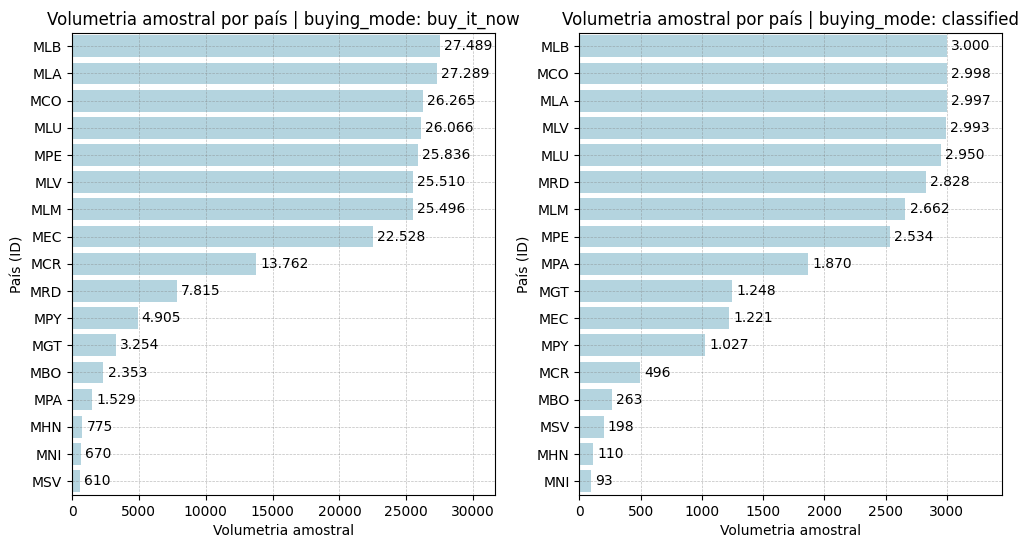

In [92]:
fig, axes = plt.subplots(nrows = 1, ncols = len(modes), figsize = (12, 6))

for ax, mode in zip(axes, modes):
    df_mode = df_counts[df_counts['buying_mode'] == mode]
    
    df_mode_sorted = df_mode.sort_values(by = 'count', ascending=False)
    
    sns.barplot(
        data=df_mode_sorted,
        y = 'site_id',
        x = 'count',
        ax = ax,
        color = 'lightblue',
        order=df_mode_sorted['site_id']
    )
    
    ax.set_title(f"Volumetria amostral por país | buying_mode: {mode}")
    ax.set_xlabel("Volumetria amostral")
    ax.set_ylabel("País (ID)")
    
    for container in ax.containers:
        labels = [f"{bar.get_width():,.0f}".replace(',', '.') for bar in container]
        ax.bar_label(container, labels=labels, fmt="", padding=3)
    
    ax.set_xlim(0, df_mode_sorted['count'].max() * 1.15)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    
plt.show()

In [93]:
df_raw['domain_id_tratado'] = df_raw.domain_id.apply(lambda x: x[4:])
df_raw[df_raw.site_id == 'MLB']['domain_id_tratado'].unique()

array(['SUPPLEMENTS', 'ELECTRIC_AIR_PUMPS', 'BICYCLE_TRAINERS', ...,
       'INSPECTION_CHAMBER_RISERS', 'TOILET_BASE_RISERS', 'WHEELBARROWS'],
      dtype=object)

In [94]:
count_domain_per_categ_id = (
    df_raw
    .groupby('domain_id_tratado')['category_id_tratado']
    .nunique()
)

len(count_domain_per_categ_id[count_domain_per_categ_id > 1])


2764

In [95]:
df_raw['domain_id_tratado'] = df_raw.domain_id.apply(lambda x: x[4:])

(
    df_raw
    .groupby('site_id',as_index=False)['domain_id_tratado']
    .value_counts(normalize=True)
    .groupby('site_id', as_index=False)
    .head(1)
)

,site_id,domain_id_tratado,proportion
0,MBO,CELLPHONES,0.098242
374,MCO,BOOKS,0.033421
2086,MCR,PERFUMES,0.051340
3381,MEC,BOOKS,0.035244
5185,MGT,OTHER_SERVICES,0.164371
5607,MHN,NOTEBOOKS,0.160452
5779,MLA,CARS_AND_VANS,0.032920
7926,MLB,CARS_AND_VANS,0.032799
10100,MLM,BOOKS,0.033063
12180,MLU,CARS_AND_VANS,0.030018


In [96]:
df_raw[(df_raw.site_id == 'MLB') & (df_raw.domain_id_tratado == 'CARS_AND_VANS')].groupby('buying_mode').size()

buying_mode
classified    1000
dtype: int64

In [97]:
df_raw = df_raw.drop('domain_id', axis = 1)

# Análises de features no formato `Struct`

## Feature: `sale_price`

In [98]:
df_raw.sale_price.iloc[1]

{'amount': 36.89,
 'conditions': {'context_restrictions': array(['channel_marketplace'], dtype=object),
  'eligible': True,
  'end_time': '2025-02-13T04:59:59Z',
  'start_time': '2025-01-14T05:00:00Z'},
 'currency_id': 'USD',
 'exchange_rate': None,
 'metadata': {'buy_quantity': None,
  'campaign_discount_percentage': None,
  'campaign_end_date': None,
  'campaign_id': None,
  'discount_meli_amount': None,
  'experiment_id': None,
  'funding_mode': None,
  'order_item_price': None,
  'pay_quantity': None,
  'promotion_id': 'OFFER-MEC585311472-10735768559',
  'promotion_type': 'custom',
  'purchase_discount_campaign_id': None,
  'purchase_discount_id': None,
  'purchase_discount_percentage': None,
  'purchase_discount_type': None,
  'variation': None},
 'payment_method_prices': array([], dtype=object),
 'payment_method_type': 'TMP',
 'price_id': '',
 'regular_amount': 44.99,
 'type': 'promotion'}

In [99]:
# Features de sale_price
df_raw['sale_price_conditions'] = df_raw.sale_price.apply(lambda x: unpack_feature(x, 'conditions'))
df_raw['sale_price_metadata'] = df_raw.sale_price.apply(lambda x: unpack_feature(x, 'metadata'))
df_raw['sale_price_payment_method_type'] = df_raw.sale_price.apply(lambda x: unpack_feature(x, 'payment_method_type'))

In [100]:
# Features de sale_price > conditions
df_raw['sale_price_conditions_start_time'] = df_raw.sale_price_conditions.apply(lambda x: unpack_feature(x, 'start_time'))
df_raw['sale_price_conditions_end_time'] = df_raw.sale_price_conditions.apply(lambda x: unpack_feature(x, 'end_time'))
df_raw['sale_price_conditions_eligible'] = df_raw.sale_price_conditions.apply(lambda x: unpack_feature(x, 'eligible'))
df_raw['sale_price_conditions_context_restrictions'] = df_raw.sale_price_conditions.apply(lambda x: unpack_feature(x, 'context_restrictions'))

df_raw = df_raw.drop('sale_price_conditions', axis = 1)

# Features de sale_price > metadata
df_raw['sale_price_metadata_promotion_type'] = df_raw.sale_price_metadata.apply(lambda x: unpack_feature(x, 'promotion_type'))

In [101]:
df_raw['sale_price_conditions_start_time'] = pd.to_datetime(df_raw['sale_price_conditions_start_time'], errors = 'coerce')
df_raw['sale_price_conditions_end_time'] = pd.to_datetime(df_raw['sale_price_conditions_end_time'], errors = 'coerce')
df_raw['stop_time'] = pd.to_datetime(df_raw['stop_time'], errors = 'coerce')

In [102]:
df_raw['diff_start_end_time'] = (df_raw['sale_price_conditions_end_time'] - df_raw['sale_price_conditions_start_time']).dt.days
df_raw['diff_start_stop_time'] = (df_raw['stop_time'] - df_raw['sale_price_conditions_start_time']).dt.days

df_raw[['diff_start_end_time', 'diff_start_stop_time']].head()

,diff_start_end_time,diff_start_stop_time
0,NaN,NaN
1,29.0,7185.0
2,30.0,7062.0
3,30.0,7040.0
4,30.0,7033.0


In [103]:
df_raw['sale_price_conditions_eligible'].value_counts(dropna=False)

True    227834
None     43806
Name: sale_price_conditions_eligible, dtype: int64

In [104]:
print(df_raw['sale_price_conditions_context_restrictions'].apply(lambda vec: 0 if vec is None else len(vec)).max())
print(df_raw['sale_price_conditions_context_restrictions'].apply(lambda vec: 0 if vec is None else str(vec)).unique())

1
['[]' "['channel_marketplace']" 0]


In [105]:
df_raw['channel_marketplace_flag'] = df_raw['sale_price_conditions_context_restrictions'].apply(lambda vec: 0 if vec is None or str(vec) == '[]' else 1)
df_raw[df_raw['channel_marketplace_flag'] == 1].shape

(66809, 42)

In [106]:
df_raw['sale_price_payment_method_type'].value_counts(dropna = False)

TMP     227834
None     43806
Name: sale_price_payment_method_type, dtype: int64

In [107]:
df_raw['sale_price_type'] = df_raw.sale_price.apply(lambda x: unpack_feature(x, 'type'))
df_raw['sale_price_type'].value_counts(dropna=False)

standard     165789
promotion     61759
None          43806
BNSP            185
SPONTH           96
BNGM              5
Name: sale_price_type, dtype: int64

### Criação das targets (`promotion_flag` e `promotion_perc`)

Como o objetivo do case é, em suma, predizer se um produto deve entrar em promoção, bem como quantificar esta. Logo, a primeira target é obtida diretamente da feature `sale_price`, em que há a indicadora `flag` com as categorias: 'promotion, 'standard', 'BNSP', 'SPONTH', 'BNGM'. Sendo assim, binarizando-a: se esta for igual a 'promotion', adotaremos uma flag 1 e 0 caso contrário. Ademais, após esse tratamento, pode-se notar que o caso passa a ser um pouco desbalanceado (aproximadamente, 77% items não promocionais e 23% promocionais).

Por sua vez, para quantificar a promoção será adotado um modelo de regressão para prever o percentual do desconto, uma vez que há inúmeras moedas (dólar, peso, real, etc) e, portanto, as diferenças absolutas não são equiparáveis. Ainda, para essa abordagem, será utilizado somente amostras que foram (ou são) promoções para não confudir o modelo, dado que produtos que não são promocionais não apresentam descontos, obviamente.

In [108]:
df_raw['promotion_flag'] = (df_raw['sale_price_type'] == 'promotion').astype(int)

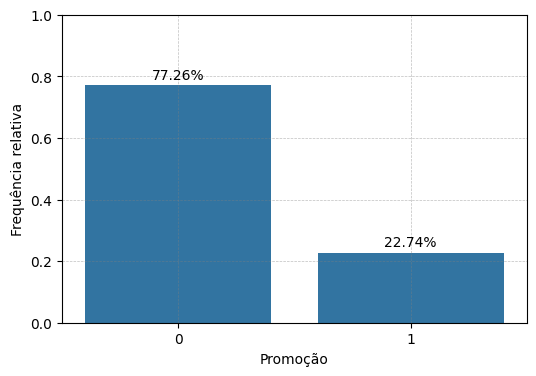

In [109]:
plt.figure(figsize=(6, 4))

ax = sns.barplot(
    x=df_raw.promotion_flag.value_counts().index, 
    y=df_raw.promotion_flag.value_counts(normalize=True).values
)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height()*100:.2f}%', 
        (p.get_x() + p.get_width() / 2., p.get_height() + .01), 
        ha = 'center', 
        va = 'center', 
        fontsize = 10, 
        color = 'black', 
        xytext = (0, 5), 
        textcoords = 'offset points'
    )

plt.ylabel('Frequência relativa')
plt.xlabel('Promoção')
plt.ylim(0, 1)
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5, color = 'gray', alpha = 0.5)
plt.show()

Produtos promocionais tendem a ser, na extrema maioria das vezes, novos:

In [110]:
(
    df_raw
    .groupby('promotion_flag')['condition']
    .value_counts(normalize=True)
    .reset_index(name='relative_freq')
)

,promotion_flag,condition,relative_freq
0,0,new,0.869762
1,0,used,0.119414
2,0,not_specified,0.010824
3,1,new,0.999887
4,1,used,0.000113


In [111]:
(
    df_raw
    .groupby('promotion_flag')['sale_price_payment_method_type']
    .value_counts(normalize=True, dropna = False)
    .reset_index(name='relative_freq')
)

,promotion_flag,sale_price_payment_method_type,relative_freq
0,0,TMP,0.791282
1,0,NaN,0.208718
2,1,TMP,1.000000


In [112]:
(
    df_raw
    .groupby('promotion_flag')['sale_price_metadata_promotion_type']
    .value_counts(normalize=True, dropna = False)
    .reset_index(name='relative_freq')
)

,promotion_flag,sale_price_metadata_promotion_type,relative_freq
0,0,NaN,1.000000
1,1,campaign,0.372998
2,1,custom,0.344986
3,1,marketplace_campaign,0.256967
4,1,deal_of_the_day,0.018394
5,1,lightning,0.006655


A feature `diff_start_end_time` (diferença entre o tempo final de listagem e tempo inicial) aparenta discriminar bastante um item promocional do não promocional, no entanto, as análises abaixo colocam em dúvida se apenas items promocionais tendem a ter marcação de listagem, podendo ocasionar vazamento de dado futuro no treinamento do modelo. Logo, não será considerada para o desenvolvimento.

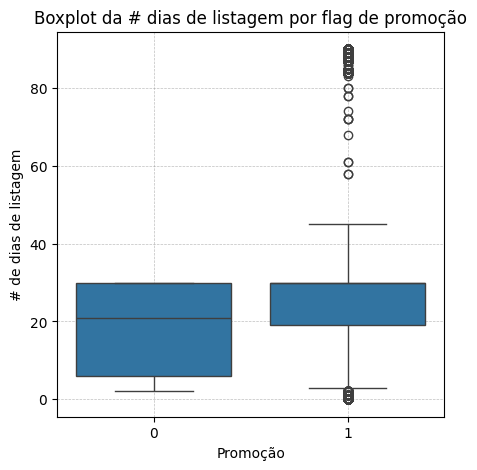

In [113]:
plt.figure(figsize=(5, 5))

sns.boxplot(x = 'promotion_flag', y = 'diff_start_end_time', data = df_raw)
plt.title('Boxplot da # dias de listagem por flag de promoção')
plt.xlabel('Promoção')
plt.ylabel('# de dias de listagem')
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5, color = 'gray', alpha = 0.5)

plt.show()

In [115]:
print(f"Quantidade de nulos (não promoção): {df_raw[df_raw.promotion_flag != 1].diff_start_end_time.isna().sum()}")
print(f"Quantidade de nulos (promoção): {df_raw[df_raw.promotion_flag == 1].diff_start_end_time.isna().sum()}")

Quantidade de nulos (não promoção): 209595
Quantidade de nulos (promoção): 0


In [120]:
df_raw[(df_raw.promotion_flag != 1) & (df_raw.diff_start_end_time.notna())].sale_price_type.value_counts(dropna=False)

BNSP      185
SPONTH     96
BNGM        5
Name: sale_price_type, dtype: int64

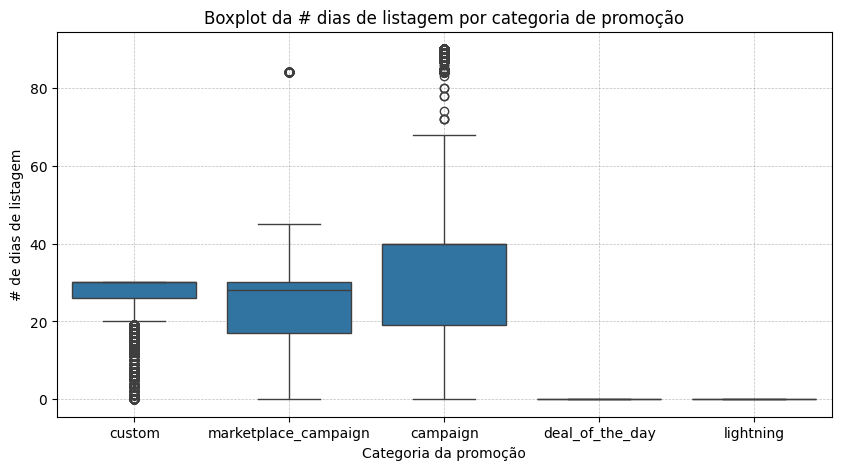

In [44]:
plt.figure(figsize=(10, 5))

sns.boxplot(
    x = 'sale_price_metadata_promotion_type', 
    y = 'diff_start_end_time', 
    data = df_raw[df_raw.promotion_flag == 1]
    )

plt.title('Boxplot da # dias de listagem por categoria de promoção')
plt.xlabel('Categoria da promoção')
plt.ylabel('# de dias de listagem')
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5, color = 'gray', alpha = 0.5)

plt.show()

Na célula abaixo, notou-se que a feature `channel_marketplace_flag` assume valores igual a 1, na maioria das vezes, quando o produto é promocional. Além disso, como não foi encontrado uma descrição clara da variável `sale_price.conditions.context_restrictions`, decidiu-se não a considerar na modelagem, uma vez que esta poderia trazer informação futura (evento de data leaky).

In [45]:
df_raw[df_raw['channel_marketplace_flag'] == 1].promotion_flag.value_counts()

1    61759
0     5050
Name: promotion_flag, dtype: int64

### Construção da target referente a quantidade de desconto atribuído a um produto.

In [46]:
print(f"""
    Quantidade de produtos com o preço original nulos (não promocional): {df_raw[df_raw.promotion_flag != 1].original_price.isnull().sum()}
    Quantidade de produtos com o preço original nulos (promocional): {df_raw[df_raw.promotion_flag == 1].original_price.isnull().sum()}
""")


    Quantidade de produtos com o preço original nulos (não promocional): 208865
    Quantidade de produtos com o preço original nulos (promocional): 0



In [47]:
df_raw.loc[(df_raw.promotion_flag == 1), 'price_tratado'] = df_raw['original_price']
df_raw.loc[(df_raw.promotion_flag != 1), 'price_tratado'] = df_raw['price']

In [48]:
df_raw = df_raw.drop(
    df_raw[(df_raw.price_tratado.isna())].index
).reset_index(drop=True)

Calcularemos o desconto por meio de:  

desconto = $\left(\frac{X - Y}{X} \right)$, 

sendo $X$ e $Y$ os valores de `original_price` e `price`, respectivamente.

In [49]:
df_raw['discount'] = ((df_raw['original_price'] - df_raw['price'].fillna(0)) / df_raw['original_price']).fillna(0)

df_raw[df_raw.promotion_flag == 1]['discount'].describe(percentiles = [i/100 for i in range(0, 101, 10)])

count    61759.000000
mean         0.227065
std          0.151044
min          0.000043
0%           0.000043
10%          0.050026
20%          0.090943
30%          0.120000
40%          0.150000
50%          0.200000
60%          0.247989
70%          0.291391
80%          0.353385
90%          0.450000
100%         0.787402
max          0.787402
Name: discount, dtype: float64

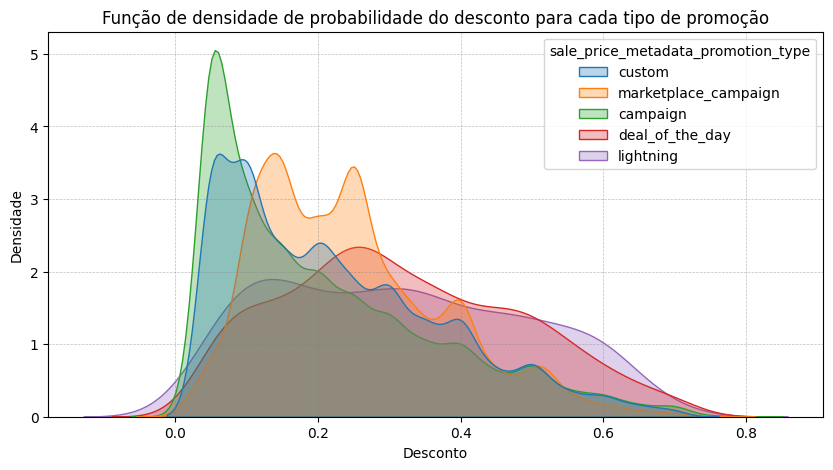

In [50]:
plt.figure(figsize=(10, 5))

sns.kdeplot(
    data = df_raw[df_raw.promotion_flag == 1],
    x = 'discount',
    hue = 'sale_price_metadata_promotion_type',
    fill = True,
    common_norm = False,
    alpha = 0.3
)

plt.title("Função de densidade de probabilidade do desconto para cada tipo de promoção")
plt.xlabel("Desconto")
plt.ylabel("Densidade")

plt.grid(True, linestyle = '--', linewidth = 0.5, color = 'gray', alpha = 0.5)
plt.show()

In [51]:
(
    df_raw[df_raw.promotion_flag == 1]
    .groupby('sale_price_metadata_promotion_type')['discount']
    .describe(percentiles = [i/100 for i in range(0, 101, 10)])
)

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
sale_price_metadata_promotion_type,,,,,,,,,,,,,,,,
campaign,23036.0,0.208314,0.159238,0.000043,0.000043,0.050000,0.059839,0.090038,0.120000,0.160000,0.200669,0.269715,0.350000,0.450000,0.787402,0.787402
custom,21306.0,0.225868,0.150943,0.049989,0.049989,0.050043,0.090393,0.100124,0.150000,0.200000,0.240000,0.300000,0.351759,0.449979,0.700088,0.700088
deal_of_the_day,1136.0,0.317628,0.164161,0.031793,0.031793,0.100000,0.163201,0.220000,0.257689,0.300000,0.350000,0.406226,0.471160,0.550000,0.717852,0.717852
lightning,411.0,0.315314,0.176090,0.030000,0.030000,0.080000,0.130127,0.190000,0.250000,0.300000,0.350101,0.428299,0.490000,0.571510,0.700000,0.700000
marketplace_campaign,15870.0,0.247123,0.130229,0.001658,0.001658,0.100000,0.130003,0.150066,0.197426,0.230002,0.250119,0.299289,0.358649,0.425223,0.757086,0.757086


In [52]:
df_raw = df_raw.drop(['sale_price', 'sale_price_metadata'], axis = 1)

## Feature: `attributes`

In [53]:
df_raw.attributes.iloc[1]

array([{'attribute_group_id': 'OTHERS', 'attribute_group_name': 'Otros', 'id': 'ALPHANUMERIC_MODEL', 'name': 'Modelo alfanumérico', 'source': 1.0, 'value_id': '41660440', 'value_name': 'M2420E1', 'value_struct': None, 'value_type': 'string', 'values': array([{'id': '41660440', 'name': 'M2420E1', 'source': 1.0, 'struct': None}],
             dtype=object)}                                                                                                                                                                                                                                                                                                              ,
       {'attribute_group_id': 'OTHERS', 'attribute_group_name': 'Otros', 'id': 'BRAND', 'name': 'Marca', 'source': 1.0, 'value_id': '59387', 'value_name': 'Xiaomi', 'value_struct': None, 'value_type': 'string', 'values': array([{'id': '59387', 'name': 'Xiaomi', 'source': 1.0, 'struct': None}],
             dtype=object)}                 

In [54]:
features_attribute = ['brand', 'color', 'main_color', 'weight']

for feature in features_attribute:
    df_raw[f'attributes_{feature}_value'] = df_raw.attributes.apply(lambda x: attribute_extract(x, feature.upper()))

In [55]:
df_raw[df_raw.attributes_brand_value.notna()].shape

(220906, 48)

### Atributo: `brand_value` (marca)

Como é de se esperar, o Mercado Livre vende produtos de diversas marcas no seu marketplace. Assim, para um modelo de machine learning é válido analisar as categorias (marcas) mais frequentes na amostra e agrupar as demais em uma mesma classe, por exemplo, `<outros>`. Portanto, analisou-se as 10 marcas mais frequentes de produtos que não estavam em promoção, bem como as mais frequentes de produtos que estavam.

In [56]:
df_raw['attributes_brand_value'] = df_raw['attributes_brand_value'].apply(brand_processing)

In [57]:
df_raw[df_raw.promotion_flag != 1].attributes_brand_value.value_counts(normalize=True).head(10)

genérica     0.048613
samsung      0.013324
sony         0.012965
xiaomi       0.008895
apple        0.008852
casio        0.007811
nintendo     0.006572
toyota       0.006380
chevrolet    0.005655
canon        0.004571
Name: attributes_brand_value, dtype: float64

In [58]:
df_raw[df_raw.promotion_flag == 1].attributes_brand_value.value_counts(normalize=True).head(10)

genérica    0.043098
truper      0.010039
samsung     0.009316
xiaomi      0.008122
sony        0.007987
total       0.007483
casio       0.006306
apple       0.005936
lenovo      0.005835
gadnic      0.004742
Name: attributes_brand_value, dtype: float64

Observe que, embora a ordem não seja a mesma (o que pode ser útil para discriminar), muitas marcas estão presentes em ambas subpopulações de tipo de venda (`sale_price_type`).

### Atributo: `color_value` e `main_color_value` (cor)

Uma outra hipótese é que a cor do produto pode discriminar e ditar se deve ser uma promoção e seu respectivo desconto, uma vez que produtos menos desejados possam ocupar mais tempo no estoque e, portanto, necessitar de promoções para serem "queimados".

Ainda, abaixo veremos que, dependendo do região, o nome da cor pode estar em inglês, espanhol ou português. Portanto, decidiu-se padronizar (pelo menos para as cores mais frequentes) para a língua inglesa.

In [59]:
df_raw.attributes_color_value.value_counts(normalize=True).head(15)

Negro           0.259266
Blanco          0.122497
Preto           0.054001
Gris            0.053282
Azul            0.049867
Plateado        0.035521
Rojo            0.028962
Branco          0.023691
Verde           0.019183
Rosa            0.017027
Amarillo        0.015245
Naranja         0.012160
Transparente    0.009674
BLACK           0.008251
Black           0.008057
Name: attributes_color_value, dtype: float64

In [60]:
df_raw['attributes_color_value'] = df_raw.attributes_color_value.apply(color_name_processing)

In [61]:
df_raw[df_raw.promotion_flag != 1].attributes_color_value.value_counts(normalize=True, dropna=True).head(10)

black      0.328791
<other>    0.201360
white      0.159686
gray       0.064814
silver     0.050112
blue       0.048827
red        0.037724
green      0.018815
yellow     0.017927
pink       0.015520
Name: attributes_color_value, dtype: float64

In [62]:
df_raw[df_raw.promotion_flag == 1].attributes_color_value.value_counts(normalize=True, dropna=True).head(10)

black      0.332430
<other>    0.230567
white      0.126912
blue       0.054016
gray       0.052724
silver     0.042846
red        0.026424
yellow     0.023090
green      0.020756
pink       0.020548
Name: attributes_color_value, dtype: float64

In [67]:
df_raw[df_raw.attributes_color_value.isna()].shape[0]

198282

In [63]:
df_raw['attributes_main_color_value'] = df_raw.attributes_main_color_value.apply(color_name_processing)

In [65]:
df_raw[df_raw.promotion_flag != 1].attributes_main_color_value.value_counts(normalize=True, dropna=True).head(10)


black      0.425411
white      0.169028
blue       0.073945
gray       0.067657
<other>    0.065081
silver     0.041594
red        0.032806
green      0.028942
pink       0.028411
yellow     0.019698
Name: attributes_main_color_value, dtype: float64

In [66]:
df_raw[df_raw.promotion_flag == 1].attributes_main_color_value.value_counts(normalize=True, dropna=True).head(10)


black      0.416489
white      0.150656
gray       0.089661
blue       0.074413
<other>    0.067094
silver     0.048084
red        0.030192
pink       0.026837
green      0.026228
yellow     0.018400
Name: attributes_main_color_value, dtype: float64

In [68]:
df_raw[df_raw.attributes_main_color_value.isna()].shape[0]

242023

### Atributo: `weight_value` (peso)

Notou-se que a variável referente ao peso (`weight_value`) é uma string que acompanha o valor e sua unidade de medida. Então, decidiu-se uniformizá-la para uma única unidade (`g`) e transformá-la em numérica. Assim, primeiramente, analisou-se quais eram as unidades de medidas presente na amostra e, posteriormente, fez o mapping de sua respectiva conversão para grama.

In [66]:
pattern = r'([\d.,]+)\s*([a-zA-Z]+)'

unit_analyses = df_raw['attributes_weight_value'].str.extract(pattern, flags=re.IGNORECASE)
unit_analyses.columns = ['valor', 'unidade']
unit_analyses.unidade.unique()

array(['kg', nan, 'g', 'lb', 'oz', 'mg', 't', 'mcg'], dtype=object)

In [68]:
df_raw['attributes_weight_value'] = df_raw['attributes_weight_value'].apply(weight_processing)

In [69]:
df_raw[df_raw.promotion_flag != 1]['attributes_weight_value'].describe()

count    3.004300e+04
mean     3.393758e+06
std      5.237565e+08
min     -3.000000e+04
25%      1.500000e+02
50%      4.000000e+02
75%      1.810000e+03
max      9.010011e+10
Name: attributes_weight_value, dtype: float64

In [70]:
df_raw[df_raw.promotion_flag == 1]['attributes_weight_value'].describe()

count    1.653200e+04
mean     1.402131e+04
std      1.803660e+05
min     -1.000000e+03
25%      1.860000e+02
50%      8.700000e+02
75%      3.200000e+03
max      1.111100e+07
Name: attributes_weight_value, dtype: float64

In [71]:
df_raw.loc[df_raw.attributes_weight_value < 0] = np.nan
df_raw[df_raw.promotion_flag == 1]['attributes_weight_value'].describe()

count    1.652900e+04
mean     1.402397e+04
std      1.803823e+05
min      0.000000e+00
25%      1.860000e+02
50%      8.770000e+02
75%      3.200000e+03
max      1.111100e+07
Name: attributes_weight_value, dtype: float64

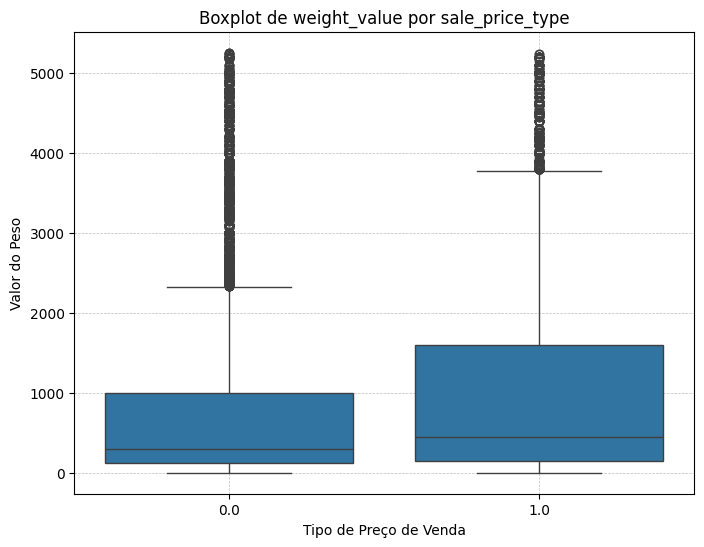

In [ ]:
plt.figure(figsize=(8, 6))

sns.boxplot(
    x = 'promotion_flag', 
    y = 'attributes_weight_value', 
    data = remove_outliers_iqr(df_raw, 'attributes_weight_value')
)

plt.title('Boxplot de weight_value por promotion_flag')
plt.xlabel('Tipo de Preço de Venda')
plt.ylabel('Valor do Peso')
plt.grid(True, linestyle = '--', linewidth = 0.5, color = 'gray', alpha = 0.5)
plt.show()

In [74]:
df_raw = df_raw.drop('attributes', axis = 1)

## Feature: `shipping` (envio)

In [75]:
df_raw.shipping.iloc[1]

{'benefits': None,
 'free_shipping': True,
 'logistic_type': 'drop_off',
 'mode': 'me2',
 'promise': None,
 'shipping_score': -1,
 'store_pick_up': False,
 'tags': array(['self_service_in', 'mandatory_free_shipping'], dtype=object)}

In [76]:
df_raw['shipping_benefits'] = df_raw.shipping.replace({np.nan: None}).apply(lambda x: unpack_feature(x, 'benefits'))
df_raw['shipping_free_shipping'] = df_raw.shipping.replace({np.nan: None}).apply(lambda x: unpack_feature(x, 'free_shipping'))
df_raw['shipping_logistic_type'] = df_raw.shipping.replace({np.nan: None}).apply(lambda x: unpack_feature(x, 'logistic_type'))
df_raw['shipping_store_pick_up'] = df_raw.shipping.replace({np.nan: None}).apply(lambda x: unpack_feature(x, 'store_pick_up'))

In [77]:
for feature in df_raw.filter(like='shipping_').columns:
    print(f'''
        Taxa de preenchimento da {feature}: {df_raw[feature].notna().sum() / df_raw.shape[0]}
    ''')


        Taxa de preenchimento da shipping_benefits: 0.0
    

        Taxa de preenchimento da shipping_free_shipping: 0.9999622725506396
    

        Taxa de preenchimento da shipping_logistic_type: 0.9186973466284865
    

        Taxa de preenchimento da shipping_store_pick_up: 0.9999622725506396
    


In [78]:
for feature in df_raw.filter(like='shipping_').columns:
    print(f"feature: {feature}")
    print(df_raw[df_raw.promotion_flag != 1][feature].value_counts(normalize=True, dropna = False))
    print()

feature: shipping_benefits
None    1.0
Name: shipping_benefits, dtype: float64

feature: shipping_free_shipping
False    0.562107
True     0.437844
None     0.000049
Name: shipping_free_shipping, dtype: float64

feature: shipping_logistic_type
not_specified    0.303360
drop_off         0.197518
cross_docking    0.137480
xd_drop_off      0.134873
None             0.105965
fulfillment      0.083973
custom           0.033541
default          0.002228
self_service     0.001062
Name: shipping_logistic_type, dtype: float64

feature: shipping_store_pick_up
False    0.999951
None     0.000049
Name: shipping_store_pick_up, dtype: float64



In [79]:
for feature in df_raw.filter(like='shipping_').columns:
    print(f"feature: {feature}")
    print(df_raw[df_raw.promotion_flag == 1][feature].value_counts(normalize=True, dropna = False))
    print()

feature: shipping_benefits
None    1.0
Name: shipping_benefits, dtype: float64

feature: shipping_free_shipping
True     0.590809
False    0.409191
Name: shipping_free_shipping, dtype: float64

feature: shipping_logistic_type
fulfillment      0.338688
cross_docking    0.262598
drop_off         0.228593
xd_drop_off      0.110273
not_specified    0.039834
default          0.013391
self_service     0.003643
custom           0.002866
None             0.000113
Name: shipping_logistic_type, dtype: float64

feature: shipping_store_pick_up
False    1.0
Name: shipping_store_pick_up, dtype: float64



In [80]:
df_raw = df_raw.drop(['shipping', 'shipping_benefits', 'shipping_store_pick_up'], axis=1)

## Feature: `address` (endereço)

In [81]:
df_raw.address.iloc[1]

{'city_id': 'RUMtUUNhcmNlbMOpbg',
 'city_name': 'Carcelén',
 'state_id': 'EC-Q',
 'state_name': 'Quito'}

In [82]:
df_raw['address_city_name'] = df_raw.address.replace({np.nan: None}).apply(lambda x: unpack_feature(x, 'city_name'))
df_raw['address_state_name'] = df_raw.address.replace({np.nan: None}).apply(lambda x: unpack_feature(x, 'state_name'))

In [83]:
df_raw['address_city_name'] = df_raw['address_city_name'].apply(
    lambda x: unidecode(x).lower() if x is not None else x
)


df_raw['address_state_name'] = df_raw['address_state_name'].apply(
    lambda x: unidecode(x).lower() if x is not None else x
)

In [84]:
for feature in df_raw.filter(like='address_').columns:
    print(f"feature: {feature}")
    print(df_raw[df_raw.promotion_flag == 1][feature].value_counts(normalize=True, dropna = False).head(15))
    print()

feature: address_city_name
tepotzotlan               0.055897
sao paulo                 0.040239
lima                      0.028807
centro                    0.025957
santiago de surco         0.017164
cuauhtemoc                0.017002
san juan de lurigancho    0.011853
cordon                    0.011837
tarqui                    0.011222
chorrillos                0.011076
martires                  0.010541
naucalpan                 0.010023
medellin                  0.009538
la victoria               0.009278
aguada                    0.009084
Name: address_city_name, dtype: float64

feature: address_state_name
lima metropolitana    0.160567
sao paulo             0.112669
montevideo            0.108799
estado de mexico      0.102678
capital federal       0.101140
buenos aires          0.064998
bogota d.c.           0.063119
distrito federal      0.051234
distrito capital      0.019010
cundinamarca          0.015302
antioquia             0.014347
quito                 0.014072
minas g

In [85]:
for feature in df_raw.filter(like='address_').columns:
    print(f"feature: {feature}")
    print(df_raw[df_raw.promotion_flag == 1][feature].value_counts(normalize=True, dropna = False).head())
    print()

feature: address_city_name
tepotzotlan          0.055897
sao paulo            0.040239
lima                 0.028807
centro               0.025957
santiago de surco    0.017164
Name: address_city_name, dtype: float64

feature: address_state_name
lima metropolitana    0.160567
sao paulo             0.112669
montevideo            0.108799
estado de mexico      0.102678
capital federal       0.101140
Name: address_state_name, dtype: float64



In [86]:
df_raw = df_raw.drop('address', axis = 1)

## Feature: `location`  (localização)

In [87]:
df_raw[df_raw.location.notna()].location

10119     {'address_line': 'Av. Occidental N46-09, Quito...
10120     {'address_line': 'Pasaje Joaquín Lalama, Quito...
10121     {'address_line': 'PGH3+8X Quito, Ecuador', 'ci...
10122     {'address_line': 'Rcto La Victoria alta 31 y 3...
10123     {'address_line': 'Manuel Cabeza de Vaca 516, Q...
                                ...                        
264562    {'address_line': 'Sin salida 144', 'city': {'i...
264563    {'address_line': '1 32', 'city': {'id': 'TVBBQ...
264564    {'address_line': 'Calle Bugabita SN', 'city': ...
264565    {'address_line': 'Subida delta Hosanna la cres...
264566    {'address_line': '1 SN', 'city': {'id': 'TVBBQ...
Name: location, Length: 22907, dtype: object

In [88]:
df_raw[df_raw.location.notna()].location.iloc[10119]

{'address_line': '',
 'city': {'id': 'TUxVQ01PTjc2Nzc', 'name': 'Montevideo'},
 'country': {'id': 'UY', 'name': 'Uruguay'},
 'latitude': -34.9055016,
 'longitude': -56.1851147,
 'neighborhood': {'id': None, 'name': None},
 'state': {'id': 'TUxVUE1PTlo2MDIy', 'name': 'Montevideo'},
 'subneighborhood': None,
 'zip_code': ''}

In [122]:
df_raw['location_city'] = df_raw.location.replace({np.nan: None}).apply(lambda x: unpack_feature(x, 'city'))
df_raw['location_city_id'] = df_raw.location_city.replace({np.nan: None}).apply(lambda x: unpack_feature(x, 'id'))
df_raw['location_city_name'] = df_raw.location_city.replace({np.nan: None}).apply(lambda x: unpack_feature(x, 'name'))

df_raw[df_raw.location.notna()][['location_city', 'location_city_id', 'location_city_name', 'address_city_name']]

,location_city,location_city_id,location_city_name,address_city_name
10119,"{'id': 'TUVDQ1FVSTIxOGZi', 'name': 'Quito'}",TUVDQ1FVSTIxOGZi,Quito,quito
10120,"{'id': 'TUVDQ1FVSTIxOGZi', 'name': 'Quito'}",TUVDQ1FVSTIxOGZi,Quito,quito
10121,"{'id': 'TUVDQ1FVSTIxOGZi', 'name': 'Quito'}",TUVDQ1FVSTIxOGZi,Quito,quito
10122,"{'id': 'TUVDQ0NVTWU2MmEx', 'name': 'Cumandá'}",TUVDQ0NVTWU2MmEx,Cumandá,cumanda
10123,"{'id': 'TUVDQ1FVSTIxOGZi', 'name': 'Quito'}",TUVDQ1FVSTIxOGZi,Quito,quito
...,...,...,...,...
264562,"{'id': 'TVBBQ01QQVNBTlRJQQ', 'name': 'Santiago'}",TVBBQ01QQVNBTlRJQQ,Santiago,santiago
264563,"{'id': 'TVBBQ01QQVNBTlRJQQ', 'name': 'Santiago'}",TVBBQ01QQVNBTlRJQQ,Santiago,santiago
264564,"{'id': 'TVBBQ01QQUJVR0FCQQ', 'name': 'Bugaba'}",TVBBQ01QQUJVR0FCQQ,Bugaba,bugaba
264565,"{'id': 'TVBBQ01QQVBBTkFNwQ', 'name': 'Panamá'}",TVBBQ01QQVBBTkFNwQ,Panamá,panama


In [125]:
print(f"Quantidade de missing na feature `location_city_name`: {df_raw[df_raw.location_city_name.isna()].shape[0]}")
print(f"Quantidade de missing na feature `address_city_name`: {df_raw[df_raw.address_city_name.isna()].shape[0]}")

Quantidade de missing na feature `location_city_name`: 242152
Quantidade de missing na feature `address_city_name`: 6209


In [127]:
df_raw['location_state'] = df_raw.location.replace({np.nan: None}).apply(lambda x: unpack_feature(x, 'state'))
df_raw['location_state_name'] = df_raw.location_state.replace({np.nan: None}).apply(lambda x: unpack_feature(x, 'name'))

df_raw[df_raw.location.notna()][['location_state_name', 'address_state_name']].head()

,location_state_name,address_state_name
10119,Pichincha ( Quito ),pichincha ( quito )
10120,Pichincha ( Quito ),pichincha ( quito )
10121,Pichincha ( Quito ),pichincha ( quito )
10122,Chimborazo,chimborazo
10123,Pichincha ( Quito ),pichincha ( quito )


In [128]:
print(f"Quantidade de missing na feature `location_state_name`: {df_raw[df_raw.location_state_name.isna()].shape[0]}")
print(f"Quantidade de missing na feature `address_state_name`: {df_raw[df_raw.address_state_name.isna()].shape[0]}")

Quantidade de missing na feature `location_state_name`: 242152
Quantidade de missing na feature `address_state_name`: 6209


A feature `location` contém informações que já extraímos da feature `address` (como cidade e estado) e se aplica somente a items classificados. Ainda, informações como rua/bairro é muito granular, podendo dificultar o poder de generalização dos modelos e, portanto, não foi considerada.

In [89]:
df_raw = df_raw.drop('location', axis = 1)

## Feature: `seller` (vendedor(a))

Como a feature `seller` traz informações sobre o(a) vendedor(a), decidiu-se por não enriquecer no modelo, uma vez que pode trazer viés de estabelecimento.

In [129]:
df_raw[df_raw.seller.notna()].seller

0               {'id': 63228264, 'nickname': 'MEGACELLCOM'}
1                {'id': 173825591, 'nickname': 'MAS_STORE'}
2                {'id': 200533006, 'nickname': 'GAMING.EC'}
3                {'id': 200533006, 'nickname': 'GAMING.EC'}
4                {'id': 200533006, 'nickname': 'GAMING.EC'}
                                ...                        
265054         {'id': 715488763, 'nickname': 'BANA3491054'}
265055         {'id': 715488763, 'nickname': 'BANA3491054'}
265056         {'id': 715488763, 'nickname': 'BANA3491054'}
265057    {'id': 809306702, 'nickname': 'ROSIBELDEESPINO...
265058         {'id': 599723638, 'nickname': 'AVVA4169656'}
Name: seller, Length: 265047, dtype: object

In [131]:
df_raw = df_raw.drop('seller', axis = 1)

## Feature: `installments` (prestação)

Abaixo, observa-se que o número de prestações permitidas de um produto não apresenta uma distribuição diferente entre os produtos promocionais e não promocionais. Ainda, há alguns outliers, correspondente a 36 parcelas máximas, aparentemente se referem algum ingresso de evento festivo.

Por sua vez, as outras duas features extraídas (`additional_bank_interest` e `meliplus_installments`) apresentam distribuições bem diferentes entre as duas categorias da target, no entanto, assumem apenas valores nulos ou 'False'. Devido a essa incerteza, não serão consideradas no desenvolvimento dos modelos.

In [132]:
df_raw[df_raw.installments.notna()].installments

34633     {'amount': 6266.81, 'currency_id': 'ARS', 'met...
34634     {'amount': 12756.02, 'currency_id': 'ARS', 'me...
34635     {'amount': 2694.95, 'currency_id': 'ARS', 'met...
34636     {'amount': 6796.94, 'currency_id': 'ARS', 'met...
34637     {'amount': 16102.28, 'currency_id': 'ARS', 'me...
                                ...                        
232829    {'amount': 8.76, 'currency_id': 'MXN', 'metada...
232830    {'amount': 57.41, 'currency_id': 'MXN', 'metad...
232831    {'amount': 83.0, 'currency_id': 'MXN', 'metada...
232832    {'amount': 15.28, 'currency_id': 'MXN', 'metad...
232833    {'amount': 49.0, 'currency_id': 'MXN', 'metada...
Name: installments, Length: 118407, dtype: object

In [133]:
df_raw[df_raw.installments.notna()].installments.iloc[34633]

{'amount': 6400.0,
 'currency_id': 'COP',
 'metadata': {'additional_bank_interest': False,
  'meliplus_installments': False},
 'quantity': 12.0,
 'rate': 0.0}

In [138]:
df_raw['installments_metadata'] = df_raw.installments.replace({np.nan: None}).apply(lambda x: unpack_feature(x, 'metadata'))
df_raw['installments_quantity'] = df_raw.installments.replace({np.nan: None}).apply(lambda x: unpack_feature(x, 'quantity'))

In [139]:
df_raw['installments_metadata_additional_bank_interest'] = df_raw.installments_metadata.replace({np.nan: None}).apply(lambda x: unpack_feature(x, 'additional_bank_interest'))
df_raw['installments_metadata_meliplus_installments'] = df_raw.installments_metadata.replace({np.nan: None}).apply(lambda x: unpack_feature(x, 'meliplus_installments'))

In [142]:
df_raw.groupby('promotion_flag')['installments_quantity'].describe(percentiles=[i/100 for i in range(0, 110, 10)])

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
promotion_flag,,,,,,,,,,,,,,,,
0.0,72290.0,10.145940,6.256065,1.0,1.0,3.0,3.0,6.0,6.0,12.0,12.0,12.0,12.0,24.0,36.0,36.0
1.0,46117.0,10.751393,6.714560,1.0,1.0,3.0,5.0,6.0,6.0,12.0,12.0,12.0,12.0,24.0,24.0,24.0


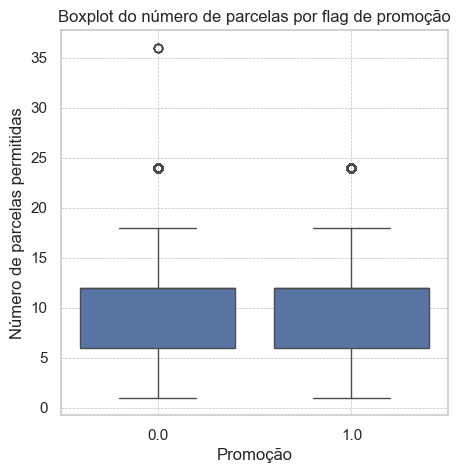

In [147]:
plt.figure(figsize=(5, 5))

sns.boxplot(x = 'promotion_flag', y = 'installments_quantity', data = df_raw)
plt.title('Boxplot do número de parcelas por flag de promoção')
plt.xlabel('Promoção')
plt.ylabel('Número de parcelas permitidas')
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5, color = 'gray', alpha = 0.5)

plt.show()

In [152]:
df_raw[df_raw['installments_quantity'] == df_raw['installments_quantity'].max()].title

71107    Vendo Colección De Boletos Conciertos  Shakira...
71110    Boletas Concierto Ferxxo Calipsis Tour 2024 Me...
71112    Boleta Concierto Feid 6 Diciembre Medellín Ori...
71113                      Boleta Shakira Barranquilla Vip
71114    Entradas Aventura Cali 21/dic/2024 Acceso Gene...
71115                              Boleta Concierto Fercho
Name: title, dtype: object

In [145]:
(
    df_raw
    .groupby('promotion_flag')['installments_metadata_additional_bank_interest']
    .value_counts(normalize=True, dropna=False)
)

promotion_flag  installments_metadata_additional_bank_interest
0.0             NaN                                               0.718884
                False                                             0.281087
                True                                              0.000030
1.0             False                                             0.589967
                NaN                                               0.410033
Name: installments_metadata_additional_bank_interest, dtype: float64

In [146]:
(
    df_raw
    .groupby('promotion_flag')['installments_metadata_meliplus_installments']
    .value_counts(normalize=True, dropna=False)
)

promotion_flag  installments_metadata_meliplus_installments
0.0             NaN                                            0.718884
                False                                          0.281116
1.0             False                                          0.589967
                NaN                                            0.410033
Name: installments_metadata_meliplus_installments, dtype: float64